# Marcell Mesterházi - AIT Project work

## Where am I?
### For the Milestone 2 I tried several models to classificate the dermathological cases
### What I achieved:
*   Preprocessed the data for the models  - different methods for Torch and Tensorflow
*   Tried out these models with a smaller amount of data
*   Tried out several PreTrained Neural Networks

### What to do:
*   Run the whole data -for 10000 images approx 5 hours and I have to wait right now to give Colab GPU again 😅
*   Merge the datasets - ISIC with DermaMNIST - (28,28,3) to (224,224,3)?  
*   Val loss and val accuracy does not decreasing in some cases
*   evaluateing the results - I cannot evaluate correctly until I did not trained he model with the whole dataset


### Conclusion

###### **I will try to use torch VGG and EfficientNet as soon as I have GPU permission again**

[Link to the notebook](https://drive.google.com/file/d/1VY6n9Q1KKSbRrAVJ-4CQrH3oXrcRcm_Z/view?usp=sharing)

In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import image
from matplotlib import pyplot
import os, sys
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
metadata = pd.read_csv("/content/drive/MyDrive/DATA/ISIC_2019_Training_Metadata.csv")
metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DATA/ISIC_2019_Training_GroundTruth.csv")
df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocessing the .csv file to get the target labels

In [ ]:
del df['image']

In [ ]:
skincancers = list(df)
print('Types of skin cancers:')
print(skincancers)

Types of skin cancers:
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']


In [ ]:
dflist = np.array(df.values.tolist())
print(dflist.shape)

(25331, 9)


In [ ]:
label = np.argmax(dflist, axis=1)
print(len(label))

25331


## Reading the images
#### Image reading from JPEG files and saving to Numpy array
#### If you want to re-run this block please set the *LOAD_IMAGES* variable to True
#### It takes approx 35 minutes



In [ ]:
# Open the image form working directory
LOAD_IMAGES = False

if LOAD_IMAGES:
  FOLDER_PATH = '/content/drive/MyDrive/DATA/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'

  images = [f for f in os.listdir(FOLDER_PATH) if os.path.isfile(os.path.join(FOLDER_PATH, f))]

  print("We have overall {} images".format(len(images)))
  # currently using 10000 RGB (224, 224)images due to running memory
  images = images[:10000]

  x = np.asarray([np.asarray(Image.open(FOLDER_PATH+'/'+fname).resize((224,224))) for fname in images])
  print(x.shape)
  np.save('melanoma_ds.npy', x)
  del x

## Loading pre-saved .npy dataset

In [ ]:
ds= np.load("melanoma_ds.npy")

print(ds.shape)
print(len(ds))
print(len(label))


(10000, 224, 224, 3)
10000
25331


### Trying out on an example:

Image number: 4709, Label(1) - NV 


<function matplotlib.pyplot.show>

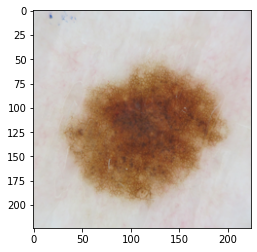

In [ ]:
import matplotlib.pyplot as plt
from random import randrange
example_img_num = randrange(len(ds))

print('Image number: {}, Label({}) - {} '.format(example_img_num, label[example_img_num], skincancers[label[example_img_num]]) )

plt.imshow(ds[example_img_num])
plt.show

#### Train - Vaildation - Test split:

In [ ]:
def split_data(X, Y, v_ratio=0.2, t_ratio=0.1):
  v_split = int(X.shape[0]*(1-v_ratio-t_ratio))
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:v_split],       Y[0:v_split]
  X_valid, Y_valid  = X[v_split:t_split], Y[v_split:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

#Keras - Transfer Learning
####data preprocessing

In [ ]:
from tensorflow.keras.utils import to_categorical

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data(ds[:200], label[:200])
del ds
print("Train: {} samples".format(len(X_train)))
print("Validation: {} samples".format(len(X_valid)))
print("Test: {} samples".format(len(X_test)))

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_valid = X_valid.astype("float32")

X_train /= 255
X_test /= 255
X_valid /= 255

# convert output to one-hot encoding
nb_classes=9
Y_train = to_categorical(Y_train, nb_classes)
Y_test = to_categorical(Y_test, nb_classes)
Y_valid = to_categorical(Y_valid, nb_classes)

Train: 140 samples
Validation: 40 samples
Test: 20 samples


## Keras **ResNet50** Pretrained model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import backend as K
num_classes = 9

In [ ]:
from tensorflow.keras.initializers import HeNormal
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))


x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', metrics=['accuracy'],
              loss='categorical_crossentropy')

In [ ]:
epochs = 40


hist = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Epoch 1/10
5/5 [==============================] - 45s 8s/step - loss: 2.4130 - accuracy: 0.1429 - val_loss: 14.7811 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 39s 8s/step - loss: 1.9741 - accuracy: 0.2929 - val_loss: 10.2103 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 39s 8s/step - loss: 1.4655 - accuracy: 0.5286 - val_loss: 6.9281 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 39s 8s/step - loss: 1.1383 - accuracy: 0.6643 - val_loss: 4.2555 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 39s 8s/step - loss: 0.7689 - accuracy: 0.7286 - val_loss: 2.8723 - val_accuracy: 0.3500
Epoch 6/10
5/5 [==============================] - 46s 8s/step - loss: 0.6383 - accuracy: 0.7786 - val_loss: 2.3714 - val_accuracy: 0.3500
Epoch 7/10
5/5 [==============================] - 40s 8s/step - loss: 0.7132 - accuracy: 0.7857 - val_loss: 2.1085 - val_accuracy: 0.3500
Epoch 8/10
5/5 [

In [ ]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-het8rr87
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-het8rr87
  Running command git submodule update --init --recursive -q


## Keras **EfficientNet** Pretrained model

In [ ]:
import tensorflow.keras.applications.efficientnet as efn
#base_model2 = efn.EfficientNetB0(weights='imagenet', input_shape=(224, 224, 3))
#model = efn.EfficientNetV2S(weights='imagenet', input_shape=(224, 224, 3))  # or weights='noisy-student'

In [ ]:
from tensorflow.keras import layers

# For EfficientNet I used this type of solution, the above one does not worked propely with EfficientNet

IMG_SIZE = 224

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
outputs = EfficientNetB0(include_top=True, weights=None, classes=9)(inputs)

model_ef = tensorflow.keras.Model(inputs, outputs)
model_ef.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model_ef.summary()

epochs = 39
hist = model_ef.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=2)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 9)                4061100   
                                                                 
Total params: 4,061,100
Trainable params: 4,019,077
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/39
5/5 - 49s - loss: 5.0973 - accuracy: 0.1000 - val_loss: 1.9790 - val_accuracy: 0.3500 - 49s/epoch - 10s/step
Epoch 2/39
5/5 - 35s - loss: 3.0693 - accuracy: 0.4000 - val_loss: 1.9021 - val_accuracy: 0.3500 - 35s/epoch - 7s/step
Epoch 3/39
5/5 - 37s - loss: 2.0556 - accuracy: 0.6714 - val_loss: 1.6125 - val_accuracy: 0.3500 - 37s/epoch - 7s/step
Epoch 4/39
5/5 - 40s - loss: 1.1551 - accuracy: 0.6857 - val_loss: 1.6480 - val_ac

KeyboardInterrupt: ignored

## Evaluation

In [ ]:
#evaluation

score, acc = model_ef.evaluate(X_test, Y_test,
                            batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
yy_test = np.argmax(Y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yy_test,y_pred)
cm

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
# evaluation from class

import numpy as np
from sklearn.metrics import confusion_matrix

preds = model.predict(X_test)
y_pred = np.round(preds) 

import seaborn as sns

ax= plt.subplot()

cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(skincancers); ax.yaxis.set_ticklabels(skincancers);

# Pytorch CNN:
## Data preprocessing

In [ ]:
import torch

# converting training images into torch format from (224,224 ,3) -> (3,224,224)
ds = ds.reshape(len(ds), 3, 224, 224)
ds  = torch.from_numpy(ds[:200])

# the torch NN works only with torch type
label = label.astype(int)
label = torch.from_numpy(label[:200])

# shape of training data
ds.shape, label.shape

(torch.Size([200, 3, 224, 224]), torch.Size([200]))

In [ ]:
label = label[:200]
len(label)

200

In [ ]:
#splitting the data

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data(ds, label)
del ds
print("Train: {} samples".format(len(X_train)))
print("Validation: {} samples".format(len(X_valid)))
print("Test: {} samples".format(len(X_test)))

Train: 140 samples
Validation: 40 samples
Test: 20 samples


## Torch Basic CNN

### I will not use this, just tried out of curiosity

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(8 * 56 * 56, 2)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
import torch.optim

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

In [ ]:
#X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data(ds, label)

from tqdm import tqdm


batch_size = 128

n_epochs = 50

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
        
    permutation = torch.randperm(X_train.size()[0])

    training_loss = []
    for i in tqdm(range(0,X_train.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], Y_train[indices]
        batch_x = batch_x.float()
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


epoch: 	 1 	 training loss: 	 0.5311457067728043


100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


epoch: 	 2 	 training loss: 	 0.4453877955675125


100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


epoch: 	 3 	 training loss: 	 0.31245312839746475


100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


epoch: 	 4 	 training loss: 	 0.44217991828918457


100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


epoch: 	 5 	 training loss: 	 0.3231969103217125


100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


epoch: 	 6 	 training loss: 	 0.4988972991704941


100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


epoch: 	 7 	 training loss: 	 0.3191017508506775


100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


epoch: 	 8 	 training loss: 	 0.43012410402297974


100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


epoch: 	 9 	 training loss: 	 0.3937966078519821


100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

epoch: 	

 10 	 training loss: 	 0.4760560989379883


100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


epoch: 	 11 	 training loss: 	 0.307618111371994


100%|██████████| 2/2 [00:00<00:00, 13.09it/s]


epoch: 	 12 	 training loss: 	 0.6482917070388794


100%|██████████| 2/2 [00:00<00:00, 13.35it/s]


epoch: 	 13 	 training loss: 	 0.3443946838378906


100%|██████████| 2/2 [00:00<00:00, 12.91it/s]


epoch: 	 14 	 training loss: 	 0.4851061850786209


100%|██████████| 2/2 [00:00<00:00, 12.77it/s]


epoch: 	 15 	 training loss: 	 0.32901421189308167


100%|██████████| 2/2 [00:00<00:00, 13.27it/s]


epoch: 	 16 	 training loss: 	 0.38939520716667175


100%|██████████| 2/2 [00:00<00:00, 13.11it/s]


epoch: 	 17 	 training loss: 	 0.3260063976049423


100%|██████████| 2/2 [00:00<00:00, 13.02it/s]


epoch: 	 18 	 training loss: 	 0.40243391692638397


100%|██████████| 2/2 [00:00<00:00, 13.52it/s]


epoch: 	 19 	 training loss: 	 0.21787698194384575


100%|██████████| 2/2 [00:00<00:00, 12.97it/s]


epoch: 	 20 	 training loss: 	 0.322035476565361


100%|██████████| 2/2 [00:00<00:00, 13.37it/s]


epoch: 	 21 	 training loss: 	 0.3812619298696518


100%|██████████| 2/2 [00:00<00:00, 12.72it/s]


epoch: 	 22 	 training loss: 	 0.40324728190898895


100%|██████████| 2/2 [00:00<00:00, 13.03it/s]


epoch: 	 23 	 training loss: 	 0.29580456018447876


100%|██████████| 2/2 [00:00<00:00, 13.39it/s]


epoch: 	 24 	 training loss: 	 0.28552666306495667


100%|██████████| 2/2 [00:00<00:00, 13.25it/s]


epoch: 	 25 	 training loss: 	 0.2798265814781189


100%|██████████| 2/2 [00:00<00:00, 13.25it/s]


epoch: 	 26 	 training loss: 	 0.2360113337635994


100%|██████████| 2/2 [00:00<00:00, 12.79it/s]


epoch: 	 27 	 training loss: 	 0.2642960101366043


100%|██████████| 2/2 [00:00<00:00, 13.00it/s]


epoch: 	 28 	 training loss: 	 0.3260996341705322


100%|██████████| 2/2 [00:00<00:00, 12.99it/s]


epoch: 	 29 	 training loss: 	 0.2714173048734665


100%|██████████| 2/2 [00:00<00:00, 12.94it/s]


epoch: 	 30 	 training loss: 	 0.3337773382663727


100%|██████████| 2/2 [00:00<00:00, 12.66it/s]


epoch: 	 31 	 training loss: 	 0.2397976592183113


100%|██████████| 2/2 [00:00<00:00, 13.04it/s]


epoch: 	 32 	 training loss: 	 0.23955726623535156


100%|██████████| 2/2 [00:00<00:00, 13.06it/s]


epoch: 	 33 	 training loss: 	 0.3298051804304123


100%|██████████| 2/2 [00:00<00:00, 13.59it/s]


epoch: 	 34 	 training loss: 	 0.32849161326885223


100%|██████████| 2/2 [00:00<00:00, 13.03it/s]


epoch: 	 35 	 training loss: 	 0.22483162581920624


100%|██████████| 2/2 [00:00<00:00, 13.05it/s]


epoch: 	 36 	 training loss: 	 0.21888577193021774


100%|██████████| 2/2 [00:00<00:00, 13.20it/s]


epoch: 	 37 	 training loss: 	 0.2714644968509674


100%|██████████| 2/2 [00:00<00:00, 12.88it/s]


epoch: 	 38 	 training loss: 	 0.18305741995573044


100%|██████████| 2/2 [00:00<00:00, 13.03it/s]


epoch: 	 39 	 training loss: 	 0.29309428483247757


100%|██████████| 2/2 [00:00<00:00, 12.87it/s]


epoch: 	 40 	 training loss: 	 0.19294936209917068


100%|██████████| 2/2 [00:00<00:00, 13.12it/s]


epoch: 	 41 	 training loss: 	 0.2238941341638565


100%|██████████| 2/2 [00:00<00:00, 13.52it/s]


epoch: 	 42 	 training loss: 	 0.2863592654466629


100%|██████████| 2/2 [00:00<00:00, 12.88it/s]


epoch: 	 43 	 training loss: 	 0.1988931968808174


100%|██████████| 2/2 [00:00<00:00, 12.99it/s]


epoch: 	 44 	 training loss: 	 0.23043660074472427


100%|██████████| 2/2 [00:00<00:00, 13.02it/s]


epoch: 	 45 	 training loss: 	 0.1927524358034134


100%|██████████| 2/2 [00:00<00:00, 13.02it/s]


epoch: 	 46 	 training loss: 	 0.31432030349969864


100%|██████████| 2/2 [00:00<00:00, 13.31it/s]


epoch: 	 47 	 training loss: 	 0.18629419058561325


100%|██████████| 2/2 [00:00<00:00, 12.66it/s]


epoch: 	 48 	 training loss: 	 0.1925983503460884


100%|██████████| 2/2 [00:00<00:00, 13.05it/s]


epoch: 	 49 	 training loss: 	 0.19111799448728561


100%|██████████| 2/2 [00:00<00:00, 12.94it/s]

epoch: 	 50 	 training loss: 	 0.16937868297100067


In [ ]:
from sklearn.metrics import accuracy_score

# prediction for training set
prediction = []
target = []
permutation = torch.randperm(X_train.size()[0])
for i in tqdm(range(0,X_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices], Y_train[indices]
    batch_x = batch_x.float()

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 2/2 [00:00<00:00,  7.69it/s]

training accuracy: 	 0.86328125


### Tried out some Torch models

In [ ]:
from torchvision import models
#model = models.squeezenet1_0(pretrained=True).eval()
#model = models.efficientnet_b2(pretrained=True).eval()
#model = models.googlenet(pretrained=True).eval()
#model = models.mobilenet_v3_large(pretrained=True).eval()
model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
import torch

if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
from torchsummary import summary
#summary(model, (3, 224, 224))
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

# change the last layer input number of features 4096 - otu num classes in our case: 9

model.classifier[6] = Sequential(
                      Linear(4096, 9))
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [ ]:
import torch.optim as optim

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0005)

In [ ]:
from tqdm import tqdm


batch_size = 128

n_epochs = 20

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
        
    permutation = torch.randperm(X_train.size()[0])

    training_loss = []
    for i in tqdm(range(0,X_train.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], Y_train[indices]
        batch_x = batch_x.float()
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

100%|██████████| 2/2 [01:31<00:00, 45.96s/it]


epoch: 	 1 	 training loss: 	 1.8495660424232483


100%|██████████| 2/2 [01:36<00:00, 48.03s/it]


epoch: 	 2 	 training loss: 	 1.125906229019165


100%|██████████| 2/2 [01:31<00:00, 45.92s/it]


epoch: 	 3 	 training loss: 	 0.670528918504715


100%|██████████| 2/2 [01:28<00:00, 44.21s/it]


epoch: 	 4 	 training loss: 	 0.6072215437889099


100%|██████████| 2/2 [01:30<00:00, 45.10s/it]


epoch: 	 5 	 training loss: 	 0.5759616792201996


100%|██████████| 2/2 [01:28<00:00, 44.28s/it]


epoch: 	 6 	 training loss: 	 0.5106559842824936


100%|██████████| 2/2 [01:28<00:00, 44.31s/it]


epoch: 	 7 	 training loss: 	 0.6297279298305511


100%|██████████| 2/2 [01:27<00:00, 43.64s/it]


epoch: 	 8 	 training loss: 	 0.8272637724876404


100%|██████████| 2/2 [01:34<00:00, 47.34s/it]


epoch: 	 9 	 training loss: 	 0.3958991914987564


100%|██████████| 2/2 [01:27<00:00, 43.55s/it]


epoch: 	 10 	 training loss: 	 0.4841741621494293


100%|██████████| 2/2 [01:27<00:00, 43.72s/it]


epoch: 	 11 	 training loss: 	 0.5755764544010162


100%|██████████| 2/2 [01:26<00:00, 43.40s/it]


epoch: 	 12 	 training loss: 	 0.5144254863262177


100%|██████████| 2/2 [01:28<00:00, 44.40s/it]


epoch: 	 13 	 training loss: 	 0.5461290627717972


100%|██████████| 2/2 [01:27<00:00, 43.64s/it]


epoch: 	 14 	 training loss: 	 0.49920864403247833


100%|██████████| 2/2 [01:31<00:00, 45.58s/it]


epoch: 	 15 	 training loss: 	 0.48114168643951416


  0%|          | 0/2 [01:06<?, ?it/s]


KeyboardInterrupt: ignored

## Torch evaluation

In [ ]:

if torch.cuda.is_available():
    model = model.cuda()

prediction = []
target = []
permutation = torch.randperm(X_train.size()[0])
for i in tqdm(range(0,X_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices], Y_train[indices]
    batch_x = batch_x.float()
     
    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model.classifier(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i],prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

  0%|          | 0/2 [00:00<?, ?it/s]